In [1]:
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
root_dir = 'C:/Users/frank/data_analysis/age-classification'
path = root_dir + '/archive/train/' #이미지 경로
image_folders = os.listdir(path)
image_folders.pop(0)
image_paths = [path+image_folder for image_folder in image_folders]
modified_path = root_dir + '/archive_sample100/train/' #샘플링된 이미지가 저장될 경로
modified_image_paths = [modified_path+image_folder for image_folder in image_folders]

In [3]:
# modified_path : archive_sample100. 100개 데이터만 샘플링한 것
# 데이터를 바꾸고 싶으면 data_dir에 들어가는 path를 다른 것으로 바꿔주면 됨
data_dir = modified_path
img_height, img_width = 224, 224
batch_size = 32

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 4983 files belonging to 53 classes.
Using 3987 files for training.
Found 4983 files belonging to 53 classes.
Using 996 files for validation.


In [5]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


## Base Model

In [6]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

IMG_SHAPE = (img_height, img_width) + (3,)
base_model = tf.keras.applications.resnet.ResNet50(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

In [7]:
for image_batch, label_batch in train_ds:
    feature_batch = base_model(image_batch)
    print(feature_batch.shape)
    break

(32, 7, 7, 2048)


In [8]:
# 처음엔 base model은 train 안되게끔 하고, 임의로 맨 위층에 추가하는 layer만 train
# fine tuning하기 전 last layer를 한 번 train해줘야 한다고 함
base_model.trainable = False

In [9]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

conv2_block3_out (Activation)   (None, 56, 56, 256)  0           conv2_block3_add[0][0]           
__________________________________________________________________________________________________
conv3_block1_1_conv (Conv2D)    (None, 28, 28, 128)  32896       conv2_block3_out[0][0]           
__________________________________________________________________________________________________
conv3_block1_1_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv3_block1_1_relu (Activation (None, 28, 28, 128)  0           conv3_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_block1_2_conv (Conv2D)    (None, 28, 28, 128)  147584      conv3_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_bloc

__________________________________________________________________________________________________
conv3_block4_3_bn (BatchNormali (None, 28, 28, 512)  2048        conv3_block4_3_conv[0][0]        
__________________________________________________________________________________________________
conv3_block4_add (Add)          (None, 28, 28, 512)  0           conv3_block3_out[0][0]           
                                                                 conv3_block4_3_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_out (Activation)   (None, 28, 28, 512)  0           conv3_block4_add[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_conv (Conv2D)    (None, 14, 14, 256)  131328      conv3_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_bloc

__________________________________________________________________________________________________
conv4_block4_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block4_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block4_2_relu (Activation (None, 14, 14, 256)  0           conv4_block4_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block4_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block4_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block4_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block4_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block4_add (Add)          (None, 14, 14, 1024) 0           conv4_block3_out[0][0]           
          

__________________________________________________________________________________________________
conv5_block2_1_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block2_1_conv[0][0]        
__________________________________________________________________________________________________
conv5_block2_1_relu (Activation (None, 7, 7, 512)    0           conv5_block2_1_bn[0][0]          
__________________________________________________________________________________________________
conv5_block2_2_conv (Conv2D)    (None, 7, 7, 512)    2359808     conv5_block2_1_relu[0][0]        
__________________________________________________________________________________________________
conv5_block2_2_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block2_2_conv[0][0]        
__________________________________________________________________________________________________
conv5_block2_2_relu (Activation (None, 7, 7, 512)    0           conv5_block2_2_bn[0][0]          
__________

In [10]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x, training=False) # because of BatchNormalization?
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)
model = tf.keras.Model(inputs, outputs)

In [11]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss='mse',
              metrics=['mae'])

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

In [13]:
history = model.fit(train_ds,
                    epochs=5,
                    validation_data=val_ds)

Epoch 1/5
125/125 [==============================] - ETA: 9:47 - loss: 853.7477 - mae: 25.90 - ETA: 4:03 - loss: 663.5261 - mae: 21.28 - ETA: 3:59 - loss: 627.6954 - mae: 20.78 - ETA: 3:56 - loss: 535.4432 - mae: 18.72 - ETA: 3:55 - loss: 502.6371 - mae: 18.18 - ETA: 3:55 - loss: 472.0358 - mae: 17.62 - ETA: 3:54 - loss: 443.9080 - mae: 17.01 - ETA: 3:55 - loss: 413.1678 - mae: 16.40 - ETA: 3:53 - loss: 393.3648 - mae: 16.03 - ETA: 3:55 - loss: 378.5737 - mae: 15.78 - ETA: 3:57 - loss: 369.7825 - mae: 15.64 - ETA: 3:59 - loss: 351.4937 - mae: 15.21 - ETA: 3:59 - loss: 345.2797 - mae: 15.13 - ETA: 3:59 - loss: 335.2282 - mae: 14.96 - ETA: 3:59 - loss: 326.1970 - mae: 14.78 - ETA: 4:00 - loss: 318.6459 - mae: 14.65 - ETA: 4:01 - loss: 311.8257 - mae: 14.49 - ETA: 4:01 - loss: 309.2310 - mae: 14.48 - ETA: 4:02 - loss: 303.1802 - mae: 14.37 - ETA: 4:03 - loss: 300.0836 - mae: 14.34 - ETA: 4:04 - loss: 291.0441 - mae: 14.05 - ETA: 4:05 - loss: 287.8265 - mae: 14.02 - ETA: 4:08 - loss: 284.8

125/125 [==============================] - ETA: 9:29 - loss: 179.8553 - mae: 11.74 - ETA: 11:25 - loss: 173.1883 - mae: 11.135 - ETA: 9:53 - loss: 177.8132 - mae: 11.141 - ETA: 8:54 - loss: 184.3312 - mae: 11.38 - ETA: 8:15 - loss: 180.3294 - mae: 11.39 - ETA: 7:44 - loss: 163.4379 - mae: 10.73 - ETA: 7:20 - loss: 160.9118 - mae: 10.65 - ETA: 7:01 - loss: 157.0437 - mae: 10.53 - ETA: 6:44 - loss: 157.1609 - mae: 10.53 - ETA: 6:31 - loss: 154.2169 - mae: 10.42 - ETA: 6:19 - loss: 154.9003 - mae: 10.45 - ETA: 6:11 - loss: 155.7153 - mae: 10.48 - ETA: 6:07 - loss: 157.2546 - mae: 10.52 - ETA: 6:01 - loss: 159.0744 - mae: 10.56 - ETA: 5:54 - loss: 160.1048 - mae: 10.61 - ETA: 5:48 - loss: 160.9391 - mae: 10.63 - ETA: 5:43 - loss: 159.8573 - mae: 10.60 - ETA: 5:39 - loss: 161.2238 - mae: 10.66 - ETA: 5:36 - loss: 159.1861 - mae: 10.59 - ETA: 5:40 - loss: 159.2316 - mae: 10.61 - ETA: 5:41 - loss: 159.1906 - mae: 10.58 - ETA: 5:40 - loss: 158.3975 - mae: 10.54 - ETA: 5:42 - loss: 158.1410 - m

125/125 [==============================] - ETA: 12:26 - loss: 134.9182 - mae: 9.27 - ETA: 13:29 - loss: 131.9579 - mae: 9.32 - ETA: 12:29 - loss: 126.5199 - mae: 9.03 - ETA: 12:18 - loss: 128.2350 - mae: 9.14 - ETA: 11:42 - loss: 131.9537 - mae: 9.40 - ETA: 10:56 - loss: 134.2233 - mae: 9.53 - ETA: 10:29 - loss: 134.0513 - mae: 9.62 - ETA: 9:56 - loss: 135.6991 - mae: 9.7941 - ETA: 9:25 - loss: 135.0431 - mae: 9.759 - ETA: 9:00 - loss: 141.7814 - mae: 9.986 - ETA: 8:48 - loss: 142.4408 - mae: 9.986 - ETA: 8:38 - loss: 143.1456 - mae: 10.03 - ETA: 8:23 - loss: 144.8897 - mae: 10.13 - ETA: 8:10 - loss: 142.4849 - mae: 10.00 - ETA: 8:01 - loss: 141.4495 - mae: 9.9440 - ETA: 7:51 - loss: 138.6467 - mae: 9.837 - ETA: 7:42 - loss: 142.8174 - mae: 10.01 - ETA: 7:38 - loss: 147.7790 - mae: 10.20 - ETA: 7:38 - loss: 146.6638 - mae: 10.14 - ETA: 7:39 - loss: 147.4481 - mae: 10.16 - ETA: 7:43 - loss: 146.6929 - mae: 10.12 - ETA: 8:01 - loss: 147.5678 - mae: 10.15 - ETA: 8:07 - loss: 147.5662 - ma

125/125 [==============================] - ETA: 6:28 - loss: 149.6616 - mae: 10.20 - ETA: 7:01 - loss: 133.8411 - mae: 9.6844 - ETA: 7:33 - loss: 125.3102 - mae: 9.117 - ETA: 7:14 - loss: 134.1059 - mae: 9.463 - ETA: 7:05 - loss: 138.0316 - mae: 9.673 - ETA: 6:58 - loss: 132.2798 - mae: 9.488 - ETA: 7:00 - loss: 134.6029 - mae: 9.537 - ETA: 7:11 - loss: 131.7404 - mae: 9.449 - ETA: 7:11 - loss: 134.6153 - mae: 9.515 - ETA: 7:15 - loss: 140.0679 - mae: 9.723 - ETA: 7:43 - loss: 141.1616 - mae: 9.717 - ETA: 7:58 - loss: 142.7278 - mae: 9.784 - ETA: 8:18 - loss: 137.6797 - mae: 9.583 - ETA: 8:22 - loss: 139.8940 - mae: 9.687 - ETA: 8:22 - loss: 137.5445 - mae: 9.608 - ETA: 8:25 - loss: 136.8149 - mae: 9.599 - ETA: 8:17 - loss: 138.5855 - mae: 9.691 - ETA: 8:06 - loss: 139.5428 - mae: 9.708 - ETA: 7:56 - loss: 139.8225 - mae: 9.692 - ETA: 7:44 - loss: 138.8332 - mae: 9.673 - ETA: 7:32 - loss: 139.6753 - mae: 9.688 - ETA: 7:21 - loss: 139.8126 - mae: 9.707 - ETA: 7:10 - loss: 140.6594 - mae

125/125 [==============================] - ETA: 14:50 - loss: 152.8805 - mae: 10.522 - ETA: 10:32 - loss: 146.0166 - mae: 10.178 - ETA: 9:44 - loss: 150.1662 - mae: 10.163 - ETA: 9:20 - loss: 127.5717 - mae: 9.2055 - ETA: 8:50 - loss: 131.9463 - mae: 9.342 - ETA: 8:37 - loss: 133.7442 - mae: 9.349 - ETA: 8:17 - loss: 130.0465 - mae: 9.342 - ETA: 7:54 - loss: 130.3449 - mae: 9.259 - ETA: 7:46 - loss: 132.8978 - mae: 9.383 - ETA: 7:30 - loss: 137.9594 - mae: 9.595 - ETA: 7:14 - loss: 136.3954 - mae: 9.501 - ETA: 7:02 - loss: 136.5101 - mae: 9.476 - ETA: 6:52 - loss: 139.2571 - mae: 9.617 - ETA: 6:41 - loss: 139.6811 - mae: 9.593 - ETA: 6:32 - loss: 142.6835 - mae: 9.692 - ETA: 6:32 - loss: 143.4252 - mae: 9.744 - ETA: 6:29 - loss: 145.4064 - mae: 9.845 - ETA: 6:33 - loss: 144.9287 - mae: 9.829 - ETA: 6:39 - loss: 144.1361 - mae: 9.811 - ETA: 6:41 - loss: 143.0135 - mae: 9.775 - ETA: 6:46 - loss: 145.3533 - mae: 9.850 - ETA: 6:56 - loss: 146.9996 - mae: 9.942 - ETA: 7:03 - loss: 144.5607 

In [14]:
history.history

{'loss': [197.39060974121094,
  154.51043701171875,
  146.22727966308594,
  141.3217315673828,
  139.95436096191406],
 'mae': [11.811043739318848,
  10.36158275604248,
  9.973431587219238,
  9.773884773254395,
  9.690877914428711],
 'val_loss': [162.31515502929688,
  142.60330200195312,
  137.47726440429688,
  135.1599884033203,
  133.08627319335938],
 'val_mae': [10.688688278198242,
  9.912225723266602,
  9.651307106018066,
  9.534937858581543,
  9.438125610351562]}

In [59]:
# 실제로 True값과 Predicted값을 비교해보기 위한 코드. val_ds에서 3개만 가져와서 해봄
i = 1
image_batch_list = []
label_batch_list = []
for image_batch, label_batch in val_ds:
    image_batch_list.append(image_batch)
    label_batch_list.append(label_batch)
    i+=1
    if i == 4: break

In [77]:
import pandas as pd
for image_batch, label_batch in zip(image_batch_list, label_batch_list):
    predicted_labels = model.predict(image_batch)
    df = pd.DataFrame({'true':np.array(label_batch).reshape(-1,), 
                       'pred':predicted_labels.reshape(-1,)})
    df = df + 18
    df['diff'] = df['true']-df['pred']
    print(df)

    true       pred       diff
0     56  33.085506  22.914494
1     52  48.762360   3.237640
2     44  43.614037   0.385963
3     22  20.945236   1.054764
4     37  35.537682   1.462318
5     46  53.088711  -7.088711
6     23  35.979809 -12.979809
7     24  46.106033 -22.106033
8     52  45.370522   6.629478
9     22  31.057268  -9.057268
10    45  46.240952  -1.240952
11    18  30.134874 -12.134874
12    46  42.960335   3.039665
13    26  51.760380 -25.760380
14    31  31.363111  -0.363111
15    21  28.205471  -7.205471
16    51  46.674507   4.325493
17    36  35.242004   0.757996
18    30  39.398952  -9.398952
19    18  32.136520 -14.136520
20    26  27.204983  -1.204983
21    18  31.545412 -13.545412
22    37  34.856129   2.143871
23    50  31.094957  18.905043
24    49  47.784012   1.215988
25    32  28.720568   3.279432
26    34  32.226288   1.773712
27    37  35.427544   1.572456
28    28  44.895004 -16.895004
29    34  30.083483   3.916517
30    23  34.460999 -11.460999
31    58

In [16]:
model.save('ResNet50_Sample100_Epoch5')

INFO:tensorflow:Assets written to: ResNet50_Sample100_Epoch5\assets


C:\Users\frank\Anaconda3\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [30]:
# callback함수를 이용해서 epoch 5번마다 checkpoint 생성
# 파일 이름에 에포크 번호를 포함시킵니다(`str.format` 포맷)
checkpoint_path = "CP_ResNet50_Sample100/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 다섯 번째 에포크마다 가중치를 저장하기 위한 콜백을 만듭니다
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

In [31]:
model.save_weights(checkpoint_path.format(epoch=0))

In [32]:
history2 = model.fit(train_ds,
                     epochs=25,
                     callbacks=[cp_callback],
                     validation_data=val_ds)

Epoch 1/25
125/125 [==============================] - ETA: 4:39 - loss: 137.1599 - mae: 9.295 - ETA: 4:53 - loss: 142.4872 - mae: 9.621 - ETA: 4:37 - loss: 132.9485 - mae: 9.416 - ETA: 4:24 - loss: 135.7281 - mae: 9.526 - ETA: 4:19 - loss: 138.6781 - mae: 9.546 - ETA: 4:16 - loss: 132.5102 - mae: 9.264 - ETA: 4:14 - loss: 137.5153 - mae: 9.454 - ETA: 4:12 - loss: 137.1955 - mae: 9.446 - ETA: 4:14 - loss: 141.9282 - mae: 9.628 - ETA: 4:15 - loss: 141.3452 - mae: 9.641 - ETA: 4:14 - loss: 137.3222 - mae: 9.539 - ETA: 4:14 - loss: 139.3328 - mae: 9.633 - ETA: 4:13 - loss: 137.8413 - mae: 9.582 - ETA: 4:12 - loss: 135.1022 - mae: 9.469 - ETA: 4:10 - loss: 132.9283 - mae: 9.365 - ETA: 4:09 - loss: 133.4675 - mae: 9.420 - ETA: 4:11 - loss: 133.9731 - mae: 9.428 - ETA: 4:11 - loss: 133.6561 - mae: 9.400 - ETA: 4:11 - loss: 135.0217 - mae: 9.436 - ETA: 4:11 - loss: 134.6109 - mae: 9.436 - ETA: 4:12 - loss: 136.8298 - mae: 9.529 - ETA: 4:12 - loss: 138.3018 - mae: 9.577 - ETA: 4:13 - loss: 136.

125/125 [==============================] - ETA: 7:43 - loss: 166.3522 - mae: 10.55 - ETA: 6:43 - loss: 160.8616 - mae: 10.05 - ETA: 6:27 - loss: 145.7421 - mae: 9.5669 - ETA: 6:16 - loss: 138.1012 - mae: 9.441 - ETA: 5:58 - loss: 134.6820 - mae: 9.351 - ETA: 5:46 - loss: 132.1678 - mae: 9.284 - ETA: 5:37 - loss: 131.0779 - mae: 9.293 - ETA: 5:29 - loss: 131.9656 - mae: 9.336 - ETA: 5:23 - loss: 127.9938 - mae: 9.227 - ETA: 5:18 - loss: 134.8181 - mae: 9.504 - ETA: 5:13 - loss: 130.6342 - mae: 9.353 - ETA: 5:09 - loss: 133.6767 - mae: 9.447 - ETA: 5:05 - loss: 132.7199 - mae: 9.427 - ETA: 5:02 - loss: 131.0472 - mae: 9.343 - ETA: 4:59 - loss: 131.0936 - mae: 9.352 - ETA: 4:56 - loss: 129.3165 - mae: 9.272 - ETA: 4:54 - loss: 131.6257 - mae: 9.381 - ETA: 4:52 - loss: 133.0207 - mae: 9.427 - ETA: 4:51 - loss: 129.3492 - mae: 9.263 - ETA: 4:50 - loss: 130.6586 - mae: 9.310 - ETA: 4:50 - loss: 129.3953 - mae: 9.276 - ETA: 4:52 - loss: 128.5421 - mae: 9.288 - ETA: 4:54 - loss: 129.9232 - mae

125/125 [==============================] - ETA: 5:32 - loss: 125.4687 - mae: 8.658 - ETA: 5:15 - loss: 129.7015 - mae: 8.942 - ETA: 5:11 - loss: 119.7922 - mae: 8.597 - ETA: 5:17 - loss: 119.7867 - mae: 8.701 - ETA: 5:18 - loss: 115.9665 - mae: 8.648 - ETA: 5:18 - loss: 124.9187 - mae: 9.087 - ETA: 5:10 - loss: 119.8383 - mae: 8.853 - ETA: 5:05 - loss: 122.6449 - mae: 8.987 - ETA: 5:02 - loss: 124.2808 - mae: 9.075 - ETA: 4:58 - loss: 126.8511 - mae: 9.161 - ETA: 4:55 - loss: 123.9247 - mae: 8.949 - ETA: 4:51 - loss: 123.9832 - mae: 8.945 - ETA: 4:48 - loss: 122.4437 - mae: 8.893 - ETA: 4:46 - loss: 128.3521 - mae: 9.094 - ETA: 4:43 - loss: 128.2722 - mae: 9.099 - ETA: 4:42 - loss: 128.1421 - mae: 9.092 - ETA: 4:41 - loss: 129.6315 - mae: 9.126 - ETA: 4:40 - loss: 129.9286 - mae: 9.128 - ETA: 4:40 - loss: 128.8797 - mae: 9.084 - ETA: 4:40 - loss: 128.3978 - mae: 9.090 - ETA: 4:41 - loss: 127.0315 - mae: 9.061 - ETA: 4:43 - loss: 129.2741 - mae: 9.170 - ETA: 4:46 - loss: 131.0430 - mae:

125/125 [==============================] - ETA: 8:02 - loss: 167.9055 - mae: 10.59 - ETA: 7:47 - loss: 142.8759 - mae: 9.7206 - ETA: 7:24 - loss: 139.6124 - mae: 9.720 - ETA: 7:02 - loss: 140.8372 - mae: 9.763 - ETA: 6:45 - loss: 130.9997 - mae: 9.405 - ETA: 6:29 - loss: 132.3943 - mae: 9.418 - ETA: 6:15 - loss: 126.6226 - mae: 9.118 - ETA: 6:04 - loss: 128.5211 - mae: 9.256 - ETA: 5:54 - loss: 125.0044 - mae: 9.061 - ETA: 5:45 - loss: 125.5207 - mae: 9.082 - ETA: 5:38 - loss: 125.2096 - mae: 9.094 - ETA: 5:31 - loss: 126.0495 - mae: 9.072 - ETA: 5:24 - loss: 125.6392 - mae: 9.129 - ETA: 5:17 - loss: 125.7452 - mae: 9.111 - ETA: 5:11 - loss: 128.6159 - mae: 9.233 - ETA: 5:06 - loss: 129.5746 - mae: 9.310 - ETA: 5:01 - loss: 129.3038 - mae: 9.316 - ETA: 4:56 - loss: 127.7943 - mae: 9.261 - ETA: 4:51 - loss: 128.9549 - mae: 9.277 - ETA: 4:47 - loss: 131.0999 - mae: 9.348 - ETA: 4:43 - loss: 132.3829 - mae: 9.379 - ETA: 4:38 - loss: 134.0788 - mae: 9.446 - ETA: 4:34 - loss: 135.5805 - mae

125/125 [==============================] - ETA: 6:52 - loss: 144.0859 - mae: 9.475 - ETA: 7:15 - loss: 150.4986 - mae: 9.833 - ETA: 7:32 - loss: 138.5639 - mae: 9.315 - ETA: 7:30 - loss: 130.1919 - mae: 9.095 - ETA: 7:19 - loss: 133.3786 - mae: 9.333 - ETA: 7:06 - loss: 126.7748 - mae: 9.136 - ETA: 6:52 - loss: 126.4206 - mae: 9.183 - ETA: 6:39 - loss: 119.1389 - mae: 8.827 - ETA: 6:29 - loss: 121.7367 - mae: 8.892 - ETA: 6:18 - loss: 123.9957 - mae: 8.991 - ETA: 6:08 - loss: 123.6250 - mae: 9.018 - ETA: 6:00 - loss: 126.6546 - mae: 9.141 - ETA: 5:52 - loss: 127.3075 - mae: 9.154 - ETA: 5:44 - loss: 125.3743 - mae: 9.121 - ETA: 5:37 - loss: 124.9567 - mae: 9.095 - ETA: 5:30 - loss: 122.7142 - mae: 8.994 - ETA: 5:25 - loss: 127.8560 - mae: 9.177 - ETA: 5:19 - loss: 132.4922 - mae: 9.322 - ETA: 5:15 - loss: 132.3157 - mae: 9.299 - ETA: 5:10 - loss: 133.2686 - mae: 9.325 - ETA: 5:06 - loss: 134.0193 - mae: 9.369 - ETA: 5:02 - loss: 135.5097 - mae: 9.439 - ETA: 4:58 - loss: 136.7202 - mae:

125/125 [==============================] - ETA: 5:48 - loss: 109.1145 - mae: 9.026 - ETA: 5:42 - loss: 125.6631 - mae: 9.613 - ETA: 5:40 - loss: 122.4041 - mae: 9.151 - ETA: 5:38 - loss: 124.7014 - mae: 9.209 - ETA: 5:41 - loss: 120.2423 - mae: 9.053 - ETA: 5:46 - loss: 117.1912 - mae: 8.891 - ETA: 5:53 - loss: 122.9092 - mae: 9.079 - ETA: 5:59 - loss: 119.8645 - mae: 8.954 - ETA: 6:10 - loss: 117.4070 - mae: 8.865 - ETA: 6:15 - loss: 118.3934 - mae: 8.880 - ETA: 6:18 - loss: 117.0340 - mae: 8.826 - ETA: 6:15 - loss: 119.3272 - mae: 8.871 - ETA: 6:10 - loss: 119.5249 - mae: 8.882 - ETA: 6:04 - loss: 120.5518 - mae: 8.913 - ETA: 5:57 - loss: 123.0286 - mae: 8.985 - ETA: 5:51 - loss: 124.0554 - mae: 9.046 - ETA: 5:44 - loss: 124.0610 - mae: 9.090 - ETA: 5:37 - loss: 125.8935 - mae: 9.160 - ETA: 5:31 - loss: 126.3989 - mae: 9.162 - ETA: 5:25 - loss: 125.0132 - mae: 9.112 - ETA: 5:20 - loss: 125.3178 - mae: 9.111 - ETA: 5:16 - loss: 126.0421 - mae: 9.119 - ETA: 5:10 - loss: 125.1427 - mae:

125/125 [==============================] - ETA: 6:22 - loss: 116.2100 - mae: 7.998 - ETA: 5:41 - loss: 117.0811 - mae: 8.166 - ETA: 5:21 - loss: 119.4277 - mae: 8.414 - ETA: 5:13 - loss: 115.8594 - mae: 8.476 - ETA: 5:10 - loss: 118.4188 - mae: 8.632 - ETA: 5:07 - loss: 114.9517 - mae: 8.613 - ETA: 5:08 - loss: 124.1711 - mae: 8.970 - ETA: 5:07 - loss: 127.9874 - mae: 9.078 - ETA: 5:07 - loss: 128.1116 - mae: 8.984 - ETA: 5:08 - loss: 126.4899 - mae: 8.948 - ETA: 5:10 - loss: 129.2062 - mae: 9.113 - ETA: 5:21 - loss: 129.7876 - mae: 9.173 - ETA: 5:33 - loss: 128.1022 - mae: 9.106 - ETA: 5:39 - loss: 130.7382 - mae: 9.236 - ETA: 5:39 - loss: 131.7778 - mae: 9.227 - ETA: 5:38 - loss: 132.9496 - mae: 9.273 - ETA: 5:35 - loss: 132.8722 - mae: 9.276 - ETA: 5:30 - loss: 128.3308 - mae: 9.076 - ETA: 5:27 - loss: 127.2133 - mae: 9.038 - ETA: 5:22 - loss: 127.6538 - mae: 9.091 - ETA: 5:16 - loss: 129.7849 - mae: 9.164 - ETA: 5:11 - loss: 130.3088 - mae: 9.217 - ETA: 5:06 - loss: 128.7297 - mae:

125/125 [==============================] - ETA: 5:31 - loss: 144.1570 - mae: 9.291 - ETA: 5:26 - loss: 150.1005 - mae: 9.896 - ETA: 5:09 - loss: 144.1136 - mae: 9.906 - ETA: 5:03 - loss: 135.4501 - mae: 9.715 - ETA: 4:59 - loss: 125.7073 - mae: 9.241 - ETA: 4:55 - loss: 131.3095 - mae: 9.505 - ETA: 4:51 - loss: 124.7937 - mae: 9.243 - ETA: 4:48 - loss: 125.4098 - mae: 9.262 - ETA: 4:45 - loss: 129.1444 - mae: 9.364 - ETA: 4:42 - loss: 124.6896 - mae: 9.195 - ETA: 4:40 - loss: 124.8161 - mae: 9.127 - ETA: 4:37 - loss: 122.4334 - mae: 8.987 - ETA: 4:34 - loss: 127.1362 - mae: 9.169 - ETA: 4:34 - loss: 128.7450 - mae: 9.290 - ETA: 4:32 - loss: 128.3189 - mae: 9.278 - ETA: 4:31 - loss: 128.5917 - mae: 9.306 - ETA: 4:29 - loss: 127.2292 - mae: 9.208 - ETA: 4:28 - loss: 128.6062 - mae: 9.245 - ETA: 4:28 - loss: 129.1872 - mae: 9.279 - ETA: 4:27 - loss: 128.2512 - mae: 9.234 - ETA: 4:26 - loss: 127.0298 - mae: 9.183 - ETA: 4:26 - loss: 128.8552 - mae: 9.273 - ETA: 4:27 - loss: 128.0247 - mae:

125/125 [==============================] - ETA: 5:55 - loss: 171.4933 - mae: 10.77 - ETA: 5:24 - loss: 151.0696 - mae: 10.11 - ETA: 5:17 - loss: 128.1977 - mae: 9.1638 - ETA: 5:12 - loss: 133.9603 - mae: 9.420 - ETA: 5:07 - loss: 133.3192 - mae: 9.471 - ETA: 5:02 - loss: 124.9695 - mae: 9.239 - ETA: 4:57 - loss: 130.2148 - mae: 9.481 - ETA: 4:53 - loss: 132.3302 - mae: 9.610 - ETA: 4:49 - loss: 125.6061 - mae: 9.290 - ETA: 4:47 - loss: 120.4977 - mae: 9.048 - ETA: 4:44 - loss: 123.0295 - mae: 9.151 - ETA: 4:41 - loss: 124.8646 - mae: 9.184 - ETA: 4:38 - loss: 125.1782 - mae: 9.206 - ETA: 4:36 - loss: 126.8647 - mae: 9.268 - ETA: 4:33 - loss: 123.7127 - mae: 9.130 - ETA: 4:30 - loss: 122.2729 - mae: 9.050 - ETA: 4:28 - loss: 121.7782 - mae: 9.028 - ETA: 4:25 - loss: 119.8015 - mae: 8.947 - ETA: 4:23 - loss: 118.2591 - mae: 8.890 - ETA: 4:21 - loss: 118.9078 - mae: 8.881 - ETA: 4:19 - loss: 120.4445 - mae: 8.936 - ETA: 4:18 - loss: 120.5067 - mae: 8.928 - ETA: 4:17 - loss: 122.2905 - mae

125/125 [==============================] - ETA: 6:17 - loss: 150.5249 - mae: 9.856 - ETA: 6:54 - loss: 130.3881 - mae: 9.214 - ETA: 6:55 - loss: 133.2211 - mae: 9.084 - ETA: 7:02 - loss: 121.7812 - mae: 8.650 - ETA: 6:50 - loss: 124.6943 - mae: 8.698 - ETA: 6:34 - loss: 126.0251 - mae: 8.936 - ETA: 6:20 - loss: 132.2088 - mae: 9.193 - ETA: 6:09 - loss: 129.2148 - mae: 9.115 - ETA: 5:58 - loss: 126.0770 - mae: 9.040 - ETA: 5:48 - loss: 128.2306 - mae: 9.175 - ETA: 5:39 - loss: 123.8099 - mae: 9.001 - ETA: 5:31 - loss: 123.2098 - mae: 8.979 - ETA: 5:24 - loss: 124.2778 - mae: 9.059 - ETA: 5:17 - loss: 129.0351 - mae: 9.240 - ETA: 5:12 - loss: 129.9641 - mae: 9.274 - ETA: 5:06 - loss: 127.0326 - mae: 9.143 - ETA: 5:01 - loss: 125.8716 - mae: 9.081 - ETA: 4:59 - loss: 122.9208 - mae: 8.948 - ETA: 4:55 - loss: 123.9439 - mae: 8.999 - ETA: 4:50 - loss: 125.9310 - mae: 9.059 - ETA: 4:46 - loss: 128.5431 - mae: 9.164 - ETA: 4:41 - loss: 128.0706 - mae: 9.129 - ETA: 4:37 - loss: 126.9349 - mae:

125/125 [==============================] - ETA: 5:34 - loss: 102.2271 - mae: 8.304 - ETA: 5:03 - loss: 116.8079 - mae: 8.980 - ETA: 5:02 - loss: 109.9796 - mae: 8.664 - ETA: 5:03 - loss: 109.5159 - mae: 8.619 - ETA: 5:04 - loss: 117.9390 - mae: 8.822 - ETA: 5:29 - loss: 113.8609 - mae: 8.724 - ETA: 6:00 - loss: 110.2237 - mae: 8.577 - ETA: 6:53 - loss: 113.3899 - mae: 8.680 - ETA: 7:28 - loss: 118.1553 - mae: 8.801 - ETA: 7:56 - loss: 120.2008 - mae: 8.898 - ETA: 8:35 - loss: 121.3876 - mae: 8.957 - ETA: 8:58 - loss: 120.5068 - mae: 8.916 - ETA: 8:55 - loss: 117.5335 - mae: 8.774 - ETA: 8:56 - loss: 120.5293 - mae: 8.864 - ETA: 8:52 - loss: 120.3878 - mae: 8.892 - ETA: 8:40 - loss: 121.2494 - mae: 8.912 - ETA: 8:23 - loss: 123.2748 - mae: 8.993 - ETA: 8:06 - loss: 122.8596 - mae: 8.939 - ETA: 7:52 - loss: 124.0126 - mae: 8.951 - ETA: 7:38 - loss: 124.1736 - mae: 8.962 - ETA: 7:25 - loss: 127.0371 - mae: 9.079 - ETA: 7:12 - loss: 126.6101 - mae: 9.059 - ETA: 7:00 - loss: 126.5301 - mae:

125/125 [==============================] - ETA: 5:31 - loss: 143.2484 - mae: 9.669 - ETA: 5:34 - loss: 130.6752 - mae: 9.163 - ETA: 5:59 - loss: 121.9104 - mae: 8.930 - ETA: 6:11 - loss: 118.4841 - mae: 8.718 - ETA: 6:03 - loss: 118.5205 - mae: 8.695 - ETA: 5:59 - loss: 120.5380 - mae: 8.838 - ETA: 5:58 - loss: 118.6208 - mae: 8.783 - ETA: 5:59 - loss: 123.9533 - mae: 9.021 - ETA: 5:59 - loss: 122.5150 - mae: 8.976 - ETA: 6:02 - loss: 120.2299 - mae: 8.885 - ETA: 6:08 - loss: 116.0560 - mae: 8.697 - ETA: 6:13 - loss: 115.6641 - mae: 8.722 - ETA: 6:12 - loss: 116.9229 - mae: 8.738 - ETA: 6:10 - loss: 114.8045 - mae: 8.720 - ETA: 6:05 - loss: 115.6334 - mae: 8.714 - ETA: 6:00 - loss: 116.3048 - mae: 8.745 - ETA: 5:54 - loss: 114.7978 - mae: 8.690 - ETA: 5:48 - loss: 116.6950 - mae: 8.749 - ETA: 5:42 - loss: 118.2633 - mae: 8.786 - ETA: 5:35 - loss: 118.4532 - mae: 8.811 - ETA: 5:29 - loss: 119.2750 - mae: 8.808 - ETA: 5:24 - loss: 119.8127 - mae: 8.821 - ETA: 5:18 - loss: 125.5979 - mae:

125/125 [==============================] - ETA: 5:47 - loss: 131.2853 - mae: 9.489 - ETA: 5:42 - loss: 127.9861 - mae: 9.264 - ETA: 5:52 - loss: 132.2546 - mae: 9.226 - ETA: 5:53 - loss: 126.2239 - mae: 9.240 - ETA: 5:53 - loss: 134.5969 - mae: 9.616 - ETA: 5:56 - loss: 133.4784 - mae: 9.637 - ETA: 6:00 - loss: 132.7580 - mae: 9.557 - ETA: 6:05 - loss: 134.8538 - mae: 9.604 - ETA: 6:12 - loss: 128.3900 - mae: 9.321 - ETA: 6:21 - loss: 128.2600 - mae: 9.267 - ETA: 6:24 - loss: 123.8294 - mae: 9.078 - ETA: 6:23 - loss: 124.4186 - mae: 9.046 - ETA: 6:19 - loss: 122.6577 - mae: 9.003 - ETA: 6:13 - loss: 125.8076 - mae: 9.102 - ETA: 6:07 - loss: 124.8290 - mae: 9.089 - ETA: 6:00 - loss: 123.7074 - mae: 9.097 - ETA: 5:53 - loss: 122.7336 - mae: 9.032 - ETA: 5:47 - loss: 123.8354 - mae: 9.044 - ETA: 5:40 - loss: 122.6498 - mae: 9.024 - ETA: 5:34 - loss: 125.6655 - mae: 9.109 - ETA: 5:28 - loss: 127.5680 - mae: 9.171 - ETA: 5:22 - loss: 126.3288 - mae: 9.125 - ETA: 5:17 - loss: 126.2316 - mae:

125/125 [==============================] - ETA: 5:28 - loss: 117.7654 - mae: 8.533 - ETA: 5:09 - loss: 104.9386 - mae: 8.294 - ETA: 5:02 - loss: 109.6653 - mae: 8.567 - ETA: 5:00 - loss: 111.3480 - mae: 8.680 - ETA: 5:00 - loss: 111.1214 - mae: 8.492 - ETA: 4:55 - loss: 109.1955 - mae: 8.429 - ETA: 4:53 - loss: 106.4196 - mae: 8.333 - ETA: 4:52 - loss: 104.1271 - mae: 8.282 - ETA: 4:49 - loss: 109.6958 - mae: 8.454 - ETA: 4:47 - loss: 112.5359 - mae: 8.650 - ETA: 4:46 - loss: 115.3054 - mae: 8.697 - ETA: 4:45 - loss: 115.2317 - mae: 8.710 - ETA: 4:44 - loss: 115.1606 - mae: 8.700 - ETA: 4:43 - loss: 119.1174 - mae: 8.816 - ETA: 4:43 - loss: 117.0506 - mae: 8.746 - ETA: 4:44 - loss: 119.3302 - mae: 8.780 - ETA: 4:45 - loss: 118.3220 - mae: 8.755 - ETA: 4:47 - loss: 117.9247 - mae: 8.760 - ETA: 4:50 - loss: 119.1357 - mae: 8.798 - ETA: 4:53 - loss: 119.9350 - mae: 8.831 - ETA: 4:53 - loss: 120.8980 - mae: 8.887 - ETA: 4:53 - loss: 121.1244 - mae: 8.887 - ETA: 4:51 - loss: 122.7730 - mae:

125/125 [==============================] - ETA: 8:08 - loss: 109.4645 - mae: 8.900 - ETA: 8:35 - loss: 118.3517 - mae: 8.854 - ETA: 7:59 - loss: 112.2175 - mae: 8.539 - ETA: 7:35 - loss: 124.6296 - mae: 8.820 - ETA: 7:08 - loss: 126.9651 - mae: 8.991 - ETA: 6:48 - loss: 129.3522 - mae: 9.133 - ETA: 6:34 - loss: 125.5292 - mae: 8.971 - ETA: 6:18 - loss: 120.2682 - mae: 8.742 - ETA: 6:05 - loss: 121.1844 - mae: 8.857 - ETA: 5:54 - loss: 118.2035 - mae: 8.763 - ETA: 5:44 - loss: 119.7530 - mae: 8.787 - ETA: 5:35 - loss: 121.4442 - mae: 8.899 - ETA: 5:28 - loss: 122.3487 - mae: 8.961 - ETA: 5:21 - loss: 124.5204 - mae: 9.042 - ETA: 5:14 - loss: 121.5504 - mae: 8.914 - ETA: 5:09 - loss: 119.3981 - mae: 8.841 - ETA: 5:03 - loss: 120.5952 - mae: 8.846 - ETA: 4:58 - loss: 119.6241 - mae: 8.819 - ETA: 4:53 - loss: 119.0481 - mae: 8.828 - ETA: 4:49 - loss: 120.6158 - mae: 8.874 - ETA: 4:45 - loss: 123.7037 - mae: 8.977 - ETA: 4:41 - loss: 122.0528 - mae: 8.890 - ETA: 4:37 - loss: 120.1681 - mae:

125/125 [==============================] - ETA: 6:12 - loss: 112.4142 - mae: 8.596 - ETA: 5:29 - loss: 122.6650 - mae: 8.643 - ETA: 5:14 - loss: 114.5539 - mae: 8.416 - ETA: 5:07 - loss: 106.2255 - mae: 8.216 - ETA: 5:03 - loss: 111.0480 - mae: 8.526 - ETA: 4:58 - loss: 115.2939 - mae: 8.623 - ETA: 4:54 - loss: 125.8767 - mae: 9.044 - ETA: 4:51 - loss: 130.1365 - mae: 9.262 - ETA: 4:49 - loss: 127.9307 - mae: 9.163 - ETA: 4:47 - loss: 125.4355 - mae: 9.098 - ETA: 4:45 - loss: 120.3693 - mae: 8.875 - ETA: 4:44 - loss: 116.7752 - mae: 8.757 - ETA: 4:43 - loss: 118.9072 - mae: 8.799 - ETA: 4:43 - loss: 118.0324 - mae: 8.788 - ETA: 4:43 - loss: 119.5900 - mae: 8.833 - ETA: 4:43 - loss: 119.3849 - mae: 8.859 - ETA: 4:44 - loss: 117.2677 - mae: 8.764 - ETA: 4:45 - loss: 120.2714 - mae: 8.868 - ETA: 4:47 - loss: 122.5101 - mae: 8.940 - ETA: 4:50 - loss: 123.0486 - mae: 8.948 - ETA: 4:52 - loss: 120.9054 - mae: 8.874 - ETA: 4:52 - loss: 121.0657 - mae: 8.883 - ETA: 4:50 - loss: 121.4327 - mae:

125/125 [==============================] - ETA: 5:51 - loss: 163.7432 - mae: 10.30 - ETA: 5:35 - loss: 149.1242 - mae: 9.8810 - ETA: 5:25 - loss: 144.9425 - mae: 9.756 - ETA: 5:26 - loss: 134.2276 - mae: 9.335 - ETA: 5:18 - loss: 133.1710 - mae: 9.232 - ETA: 5:12 - loss: 126.4936 - mae: 8.999 - ETA: 5:06 - loss: 126.6276 - mae: 8.989 - ETA: 5:01 - loss: 119.8577 - mae: 8.720 - ETA: 4:56 - loss: 118.1545 - mae: 8.658 - ETA: 4:53 - loss: 118.5831 - mae: 8.671 - ETA: 4:49 - loss: 118.2146 - mae: 8.654 - ETA: 4:45 - loss: 118.3136 - mae: 8.672 - ETA: 4:42 - loss: 116.5301 - mae: 8.683 - ETA: 4:39 - loss: 115.7269 - mae: 8.661 - ETA: 4:36 - loss: 118.1752 - mae: 8.753 - ETA: 4:33 - loss: 120.1319 - mae: 8.845 - ETA: 4:31 - loss: 118.4892 - mae: 8.809 - ETA: 4:29 - loss: 120.1482 - mae: 8.839 - ETA: 4:27 - loss: 119.1766 - mae: 8.771 - ETA: 4:24 - loss: 116.8757 - mae: 8.669 - ETA: 4:23 - loss: 117.6456 - mae: 8.713 - ETA: 4:21 - loss: 117.2396 - mae: 8.719 - ETA: 4:20 - loss: 118.8664 - mae

125/125 [==============================] - ETA: 6:02 - loss: 135.2142 - mae: 9.736 - ETA: 5:56 - loss: 128.5829 - mae: 9.454 - ETA: 6:01 - loss: 112.4479 - mae: 8.575 - ETA: 6:08 - loss: 122.0410 - mae: 8.934 - ETA: 6:15 - loss: 117.0650 - mae: 8.786 - ETA: 6:12 - loss: 127.4487 - mae: 9.169 - ETA: 6:05 - loss: 125.7541 - mae: 9.210 - ETA: 5:57 - loss: 119.5086 - mae: 8.898 - ETA: 5:49 - loss: 121.6237 - mae: 8.897 - ETA: 5:42 - loss: 121.1593 - mae: 8.869 - ETA: 5:35 - loss: 121.5350 - mae: 8.866 - ETA: 5:31 - loss: 121.3560 - mae: 8.889 - ETA: 5:27 - loss: 118.7231 - mae: 8.836 - ETA: 5:25 - loss: 117.4517 - mae: 8.771 - ETA: 5:19 - loss: 116.5164 - mae: 8.740 - ETA: 5:14 - loss: 114.5127 - mae: 8.680 - ETA: 5:10 - loss: 115.2965 - mae: 8.702 - ETA: 5:05 - loss: 114.5721 - mae: 8.668 - ETA: 5:00 - loss: 116.1694 - mae: 8.703 - ETA: 4:55 - loss: 116.4588 - mae: 8.675 - ETA: 4:51 - loss: 116.5070 - mae: 8.682 - ETA: 4:46 - loss: 116.4755 - mae: 8.695 - ETA: 4:42 - loss: 114.7333 - mae:

125/125 [==============================] - ETA: 5:37 - loss: 132.9237 - mae: 8.956 - ETA: 5:23 - loss: 107.9563 - mae: 8.189 - ETA: 5:20 - loss: 116.5306 - mae: 8.773 - ETA: 5:20 - loss: 107.7609 - mae: 8.455 - ETA: 5:21 - loss: 117.6688 - mae: 8.908 - ETA: 5:27 - loss: 122.3977 - mae: 8.971 - ETA: 5:35 - loss: 118.8598 - mae: 8.846 - ETA: 5:39 - loss: 120.4545 - mae: 8.978 - ETA: 5:43 - loss: 118.7912 - mae: 8.921 - ETA: 5:49 - loss: 117.0139 - mae: 8.844 - ETA: 5:50 - loss: 118.8449 - mae: 8.891 - ETA: 5:48 - loss: 120.5450 - mae: 8.917 - ETA: 5:46 - loss: 121.4896 - mae: 8.931 - ETA: 5:41 - loss: 119.5639 - mae: 8.853 - ETA: 5:37 - loss: 122.0843 - mae: 8.863 - ETA: 5:32 - loss: 119.9973 - mae: 8.788 - ETA: 5:27 - loss: 120.8441 - mae: 8.838 - ETA: 5:21 - loss: 119.4599 - mae: 8.783 - ETA: 5:15 - loss: 119.3584 - mae: 8.765 - ETA: 5:10 - loss: 120.1788 - mae: 8.819 - ETA: 5:05 - loss: 118.9069 - mae: 8.785 - ETA: 4:59 - loss: 118.9304 - mae: 8.779 - ETA: 4:54 - loss: 120.7032 - mae:

125/125 [==============================] - ETA: 5:39 - loss: 114.3460 - mae: 8.915 - ETA: 5:11 - loss: 99.5272 - mae: 8.208 - ETA: 5:12 - loss: 109.0317 - mae: 8.512 - ETA: 5:12 - loss: 122.8522 - mae: 9.225 - ETA: 5:12 - loss: 127.0573 - mae: 9.351 - ETA: 5:13 - loss: 121.5525 - mae: 9.168 - ETA: 5:15 - loss: 119.1624 - mae: 9.048 - ETA: 5:16 - loss: 121.1227 - mae: 9.082 - ETA: 5:20 - loss: 121.8792 - mae: 9.103 - ETA: 5:24 - loss: 122.7709 - mae: 9.112 - ETA: 5:26 - loss: 124.9905 - mae: 9.205 - ETA: 5:26 - loss: 124.1146 - mae: 9.175 - ETA: 5:23 - loss: 122.4958 - mae: 9.126 - ETA: 5:19 - loss: 122.8776 - mae: 9.100 - ETA: 5:15 - loss: 121.0196 - mae: 9.030 - ETA: 5:11 - loss: 119.7090 - mae: 8.965 - ETA: 5:06 - loss: 119.1888 - mae: 8.916 - ETA: 5:01 - loss: 119.3042 - mae: 8.894 - ETA: 4:57 - loss: 119.1798 - mae: 8.861 - ETA: 4:52 - loss: 121.6886 - mae: 8.972 - ETA: 4:48 - loss: 119.9616 - mae: 8.926 - ETA: 4:43 - loss: 118.1364 - mae: 8.829 - ETA: 4:39 - loss: 119.0859 - mae: 

125/125 [==============================] - ETA: 5:53 - loss: 171.7977 - mae: 10.69 - ETA: 5:38 - loss: 150.2641 - mae: 9.9587 - ETA: 5:38 - loss: 124.2589 - mae: 8.934 - ETA: 5:40 - loss: 124.6310 - mae: 9.024 - ETA: 5:46 - loss: 123.4591 - mae: 8.970 - ETA: 5:51 - loss: 115.7263 - mae: 8.768 - ETA: 5:54 - loss: 113.5845 - mae: 8.716 - ETA: 5:55 - loss: 119.0617 - mae: 8.840 - ETA: 5:52 - loss: 119.4289 - mae: 8.797 - ETA: 5:46 - loss: 117.4840 - mae: 8.727 - ETA: 5:39 - loss: 117.8674 - mae: 8.764 - ETA: 5:33 - loss: 115.3500 - mae: 8.688 - ETA: 5:27 - loss: 121.6198 - mae: 8.907 - ETA: 5:21 - loss: 124.4667 - mae: 9.005 - ETA: 5:15 - loss: 124.4337 - mae: 9.015 - ETA: 5:09 - loss: 124.9180 - mae: 9.031 - ETA: 5:04 - loss: 122.7358 - mae: 8.929 - ETA: 4:59 - loss: 120.0748 - mae: 8.830 - ETA: 4:54 - loss: 120.7067 - mae: 8.848 - ETA: 4:49 - loss: 122.5595 - mae: 8.935 - ETA: 4:45 - loss: 121.4417 - mae: 8.898 - ETA: 4:41 - loss: 122.0733 - mae: 8.941 - ETA: 4:37 - loss: 123.3397 - mae

125/125 [==============================] - ETA: 7:38 - loss: 115.2580 - mae: 8.362 - ETA: 7:00 - loss: 127.0920 - mae: 8.882 - ETA: 6:43 - loss: 118.5803 - mae: 8.736 - ETA: 6:30 - loss: 109.9197 - mae: 8.355 - ETA: 6:15 - loss: 105.3426 - mae: 8.152 - ETA: 6:02 - loss: 114.8169 - mae: 8.576 - ETA: 5:52 - loss: 115.1793 - mae: 8.565 - ETA: 5:43 - loss: 111.8333 - mae: 8.489 - ETA: 5:36 - loss: 113.0678 - mae: 8.495 - ETA: 5:29 - loss: 115.9750 - mae: 8.625 - ETA: 5:23 - loss: 119.2010 - mae: 8.746 - ETA: 5:17 - loss: 117.4284 - mae: 8.683 - ETA: 5:11 - loss: 119.0955 - mae: 8.754 - ETA: 5:05 - loss: 117.4107 - mae: 8.742 - ETA: 5:00 - loss: 118.9799 - mae: 8.825 - ETA: 4:56 - loss: 118.7461 - mae: 8.815 - ETA: 4:51 - loss: 119.2951 - mae: 8.839 - ETA: 4:47 - loss: 118.0981 - mae: 8.818 - ETA: 4:43 - loss: 118.2231 - mae: 8.825 - ETA: 4:40 - loss: 115.3302 - mae: 8.719 - ETA: 4:36 - loss: 114.6266 - mae: 8.675 - ETA: 4:32 - loss: 114.1439 - mae: 8.644 - ETA: 4:29 - loss: 113.8383 - mae:

125/125 [==============================] - ETA: 6:40 - loss: 165.4156 - mae: 11.08 - ETA: 6:19 - loss: 154.4517 - mae: 10.18 - ETA: 6:31 - loss: 156.8633 - mae: 9.9397 - ETA: 6:23 - loss: 147.4939 - mae: 9.696 - ETA: 6:09 - loss: 132.8145 - mae: 9.139 - ETA: 5:58 - loss: 128.9215 - mae: 8.985 - ETA: 5:48 - loss: 130.8869 - mae: 9.109 - ETA: 5:39 - loss: 127.6296 - mae: 9.052 - ETA: 5:31 - loss: 125.6128 - mae: 8.986 - ETA: 5:25 - loss: 123.8674 - mae: 8.959 - ETA: 5:18 - loss: 123.9478 - mae: 8.964 - ETA: 5:12 - loss: 122.2907 - mae: 8.872 - ETA: 5:06 - loss: 120.2835 - mae: 8.808 - ETA: 5:01 - loss: 118.5961 - mae: 8.733 - ETA: 4:57 - loss: 118.9697 - mae: 8.771 - ETA: 4:52 - loss: 121.3092 - mae: 8.875 - ETA: 4:48 - loss: 121.3453 - mae: 8.893 - ETA: 4:44 - loss: 121.6557 - mae: 8.899 - ETA: 4:41 - loss: 122.8896 - mae: 8.950 - ETA: 4:37 - loss: 123.0539 - mae: 8.970 - ETA: 4:33 - loss: 123.4456 - mae: 9.002 - ETA: 4:30 - loss: 122.0368 - mae: 8.961 - ETA: 4:27 - loss: 121.6984 - mae

125/125 [==============================] - ETA: 6:55 - loss: 104.3532 - mae: 8.719 - ETA: 7:03 - loss: 106.0057 - mae: 8.488 - ETA: 7:02 - loss: 99.1072 - mae: 8.011 - ETA: 6:52 - loss: 107.4582 - mae: 8.394 - ETA: 6:40 - loss: 116.2418 - mae: 8.679 - ETA: 6:25 - loss: 118.1433 - mae: 8.724 - ETA: 6:14 - loss: 112.9517 - mae: 8.527 - ETA: 6:03 - loss: 112.7018 - mae: 8.570 - ETA: 5:52 - loss: 111.2321 - mae: 8.486 - ETA: 5:44 - loss: 116.7550 - mae: 8.673 - ETA: 5:35 - loss: 116.2616 - mae: 8.714 - ETA: 5:28 - loss: 115.5837 - mae: 8.628 - ETA: 5:22 - loss: 114.5010 - mae: 8.574 - ETA: 5:15 - loss: 114.9442 - mae: 8.596 - ETA: 5:10 - loss: 113.7306 - mae: 8.545 - ETA: 5:04 - loss: 115.1352 - mae: 8.606 - ETA: 4:59 - loss: 115.6378 - mae: 8.665 - ETA: 4:55 - loss: 115.4009 - mae: 8.660 - ETA: 4:50 - loss: 115.5415 - mae: 8.630 - ETA: 4:46 - loss: 113.6774 - mae: 8.569 - ETA: 4:42 - loss: 114.3737 - mae: 8.610 - ETA: 4:38 - loss: 116.0273 - mae: 8.653 - ETA: 4:35 - loss: 115.4102 - mae: 

125/125 [==============================] - ETA: 5:40 - loss: 79.5862 - mae: 7.09 - ETA: 5:08 - loss: 82.0159 - mae: 7.12 - ETA: 5:03 - loss: 97.9394 - mae: 7.90 - ETA: 5:02 - loss: 104.0121 - mae: 8.021 - ETA: 4:59 - loss: 104.0086 - mae: 8.058 - ETA: 4:56 - loss: 107.3493 - mae: 8.253 - ETA: 4:53 - loss: 105.5808 - mae: 8.129 - ETA: 4:51 - loss: 110.3763 - mae: 8.371 - ETA: 4:48 - loss: 108.3045 - mae: 8.301 - ETA: 4:47 - loss: 112.5139 - mae: 8.507 - ETA: 4:45 - loss: 111.0446 - mae: 8.475 - ETA: 4:44 - loss: 111.9320 - mae: 8.505 - ETA: 4:42 - loss: 110.6032 - mae: 8.450 - ETA: 4:41 - loss: 111.7631 - mae: 8.469 - ETA: 4:41 - loss: 112.1390 - mae: 8.490 - ETA: 4:41 - loss: 111.8184 - mae: 8.462 - ETA: 4:44 - loss: 115.2261 - mae: 8.615 - ETA: 4:45 - loss: 116.9239 - mae: 8.698 - ETA: 4:47 - loss: 115.0180 - mae: 8.583 - ETA: 4:50 - loss: 114.5992 - mae: 8.560 - ETA: 4:51 - loss: 114.0283 - mae: 8.524 - ETA: 4:53 - loss: 113.5605 - mae: 8.520 - ETA: 4:55 - loss: 113.8073 - mae: 8.550

In [33]:
history2.history

{'loss': [136.55918884277344,
  135.4293212890625,
  134.13174438476562,
  132.3472442626953,
  130.45748901367188,
  130.15957641601562,
  127.26055145263672,
  127.77734375,
  125.60885620117188,
  126.49747467041016,
  124.50944519042969,
  124.55692291259766,
  125.21791076660156,
  124.1411361694336,
  121.96746826171875,
  122.57499694824219,
  120.80972290039062,
  121.37034606933594,
  120.93290710449219,
  119.38407135009766,
  120.76397705078125,
  120.01040649414062,
  119.1405029296875,
  118.99960327148438,
  117.24364471435547],
 'mae': [9.518342018127441,
  9.52071475982666,
  9.457898139953613,
  9.40279483795166,
  9.334985733032227,
  9.282352447509766,
  9.187902450561523,
  9.219365119934082,
  9.143040657043457,
  9.141169548034668,
  9.04403018951416,
  9.030750274658203,
  9.115100860595703,
  9.047012329101562,
  8.951428413391113,
  8.992474555969238,
  8.899449348449707,
  8.946161270141602,
  8.91711711883545,
  8.87631893157959,
  8.918804168701172,
  8.9196

In [34]:
model.save('ResNet50_Sample100_Epoch30.h5')

## Fine Tuning : 25 layers

In [35]:
base_model.trainable = True

In [36]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [37]:
# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [38]:
# 낮은 학습률 사용
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
              loss='mse',
              metrics=['mae'])

In [39]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

In [44]:
checkpoint_path_for_fine = "CP_ResNet50_Sample100_Fine/cp-{epoch:04d}.ckpt"
checkpoint_dir_for_fine = os.path.dirname(checkpoint_path_for_fine)

cp_callback_for_fine = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_for_fine, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=2, 
    verbose=1, 
    mode='min', 
    restore_best_weights=True)

In [43]:
fine_tune_epochs = 10
total_epochs =  30 + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=30,
                         validation_data=val_ds,
                         callbacks=[cp_callback_for_fine, es_callback])

Epoch 31/40
125/125 [==============================] - ETA: 6:05 - loss: 169.2007 - mae: 10.75 - ETA: 5:41 - loss: 159.5139 - mae: 9.9876 - ETA: 5:43 - loss: 131.7289 - mae: 9.041 - ETA: 5:36 - loss: 130.4802 - mae: 8.842 - ETA: 5:32 - loss: 121.3203 - mae: 8.599 - ETA: 5:32 - loss: 119.7522 - mae: 8.553 - ETA: 5:31 - loss: 118.5592 - mae: 8.594 - ETA: 5:31 - loss: 114.6780 - mae: 8.443 - ETA: 5:30 - loss: 116.1678 - mae: 8.563 - ETA: 5:28 - loss: 115.2970 - mae: 8.586 - ETA: 5:29 - loss: 115.4514 - mae: 8.588 - ETA: 5:29 - loss: 112.7617 - mae: 8.482 - ETA: 5:28 - loss: 112.3230 - mae: 8.503 - ETA: 5:28 - loss: 114.2891 - mae: 8.544 - ETA: 5:30 - loss: 111.5775 - mae: 8.418 - ETA: 5:33 - loss: 108.6395 - mae: 8.297 - ETA: 5:40 - loss: 106.7596 - mae: 8.236 - ETA: 5:44 - loss: 105.3806 - mae: 8.209 - ETA: 5:52 - loss: 107.2619 - mae: 8.287 - ETA: 6:02 - loss: 107.6624 - mae: 8.300 - ETA: 6:10 - loss: 107.3691 - mae: 8.269 - ETA: 6:18 - loss: 107.5080 - mae: 8.282 - ETA: 6:21 - loss: 10

In [46]:
fine_tune_epochs = 10
total_epochs =  30 + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=30,
                         validation_data=val_ds,
                         callbacks=[cp_callback_for_fine, es_callback])

Epoch 31/40
125/125 [==============================] - ETA: 6:13 - loss: 79.6902 - mae: 6.72 - ETA: 6:18 - loss: 80.8350 - mae: 6.86 - ETA: 6:12 - loss: 85.2979 - mae: 7.20 - ETA: 6:07 - loss: 84.4097 - mae: 7.15 - ETA: 6:06 - loss: 84.9997 - mae: 7.32 - ETA: 6:12 - loss: 94.2617 - mae: 7.64 - ETA: 6:18 - loss: 94.6011 - mae: 7.72 - ETA: 6:28 - loss: 96.1532 - mae: 7.90 - ETA: 6:34 - loss: 95.7728 - mae: 7.95 - ETA: 6:39 - loss: 93.9580 - mae: 7.85 - ETA: 6:46 - loss: 95.8920 - mae: 7.91 - ETA: 6:57 - loss: 97.6639 - mae: 8.00 - ETA: 7:12 - loss: 98.8801 - mae: 8.04 - ETA: 7:33 - loss: 98.9585 - mae: 8.04 - ETA: 7:52 - loss: 98.5611 - mae: 8.02 - ETA: 8:04 - loss: 99.0265 - mae: 8.06 - ETA: 8:05 - loss: 98.8785 - mae: 8.05 - ETA: 8:00 - loss: 99.3461 - mae: 8.04 - ETA: 7:52 - loss: 99.7280 - mae: 8.07 - ETA: 7:45 - loss: 99.7274 - mae: 8.07 - ETA: 7:37 - loss: 98.7542 - mae: 8.00 - ETA: 7:31 - loss: 99.0866 - mae: 8.01 - ETA: 7:24 - loss: 103.2530 - mae: 8.131 - ETA: 7:16 - loss: 102.3

125/125 [==============================] - ETA: 9:35 - loss: 107.7273 - mae: 9.114 - ETA: 8:31 - loss: 89.4289 - mae: 7.894 - ETA: 9:31 - loss: 97.5589 - mae: 7.88 - ETA: 9:40 - loss: 93.8195 - mae: 7.59 - ETA: 9:21 - loss: 89.9763 - mae: 7.38 - ETA: 9:16 - loss: 92.6877 - mae: 7.57 - ETA: 9:05 - loss: 94.0096 - mae: 7.72 - ETA: 8:46 - loss: 93.9499 - mae: 7.80 - ETA: 8:32 - loss: 93.0425 - mae: 7.73 - ETA: 8:21 - loss: 93.4325 - mae: 7.78 - ETA: 8:15 - loss: 103.2429 - mae: 8.166 - ETA: 8:14 - loss: 99.6990 - mae: 7.956 - ETA: 8:22 - loss: 99.5684 - mae: 8.03 - ETA: 8:52 - loss: 99.5294 - mae: 8.02 - ETA: 8:57 - loss: 95.8321 - mae: 7.81 - ETA: 8:58 - loss: 94.7072 - mae: 7.75 - ETA: 8:52 - loss: 95.4529 - mae: 7.79 - ETA: 8:44 - loss: 94.3467 - mae: 7.73 - ETA: 8:35 - loss: 94.0645 - mae: 7.70 - ETA: 8:24 - loss: 97.3321 - mae: 7.82 - ETA: 8:13 - loss: 99.8998 - mae: 7.92 - ETA: 8:04 - loss: 100.2811 - mae: 7.924 - ETA: 7:55 - loss: 99.8457 - mae: 7.899 - ETA: 7:44 - loss: 100.2817 -

125/125 [==============================] - ETA: 9:25 - loss: 121.3193 - mae: 8.753 - ETA: 11:14 - loss: 105.9497 - mae: 8.25 - ETA: 11:16 - loss: 84.4487 - mae: 7.1656 - ETA: 11:27 - loss: 87.5657 - mae: 7.365 - ETA: 11:14 - loss: 88.2470 - mae: 7.493 - ETA: 10:48 - loss: 82.4594 - mae: 7.153 - ETA: 10:23 - loss: 84.2105 - mae: 7.316 - ETA: 9:58 - loss: 82.1786 - mae: 7.189 - ETA: 9:35 - loss: 86.1329 - mae: 7.35 - ETA: 9:13 - loss: 84.7851 - mae: 7.31 - ETA: 8:54 - loss: 83.5155 - mae: 7.25 - ETA: 8:39 - loss: 89.8730 - mae: 7.47 - ETA: 8:24 - loss: 88.5555 - mae: 7.40 - ETA: 8:10 - loss: 87.7637 - mae: 7.38 - ETA: 7:57 - loss: 87.8871 - mae: 7.38 - ETA: 7:45 - loss: 86.3984 - mae: 7.31 - ETA: 7:37 - loss: 86.0380 - mae: 7.30 - ETA: 7:30 - loss: 87.9350 - mae: 7.33 - ETA: 7:22 - loss: 89.4627 - mae: 7.36 - ETA: 7:14 - loss: 90.8141 - mae: 7.41 - ETA: 7:06 - loss: 91.6136 - mae: 7.46 - ETA: 7:00 - loss: 92.9658 - mae: 7.54 - ETA: 6:55 - loss: 93.5341 - mae: 7.58 - ETA: 6:51 - loss: 93.

125/125 [==============================] - ETA: 9:54 - loss: 94.8884 - mae: 7.43 - ETA: 8:57 - loss: 90.2083 - mae: 7.53 - ETA: 8:26 - loss: 85.9208 - mae: 7.34 - ETA: 8:06 - loss: 92.4625 - mae: 7.79 - ETA: 7:57 - loss: 96.1692 - mae: 7.96 - ETA: 7:57 - loss: 92.5040 - mae: 7.72 - ETA: 7:47 - loss: 89.4998 - mae: 7.63 - ETA: 7:35 - loss: 86.1071 - mae: 7.48 - ETA: 7:23 - loss: 86.2109 - mae: 7.43 - ETA: 7:12 - loss: 84.8533 - mae: 7.35 - ETA: 7:03 - loss: 82.3008 - mae: 7.21 - ETA: 6:55 - loss: 85.1542 - mae: 7.33 - ETA: 6:48 - loss: 88.5774 - mae: 7.44 - ETA: 6:41 - loss: 87.4872 - mae: 7.39 - ETA: 6:36 - loss: 86.6517 - mae: 7.41 - ETA: 6:31 - loss: 86.0710 - mae: 7.37 - ETA: 6:27 - loss: 86.4625 - mae: 7.39 - ETA: 6:23 - loss: 86.1414 - mae: 7.38 - ETA: 6:20 - loss: 84.6175 - mae: 7.32 - ETA: 6:18 - loss: 84.3685 - mae: 7.30 - ETA: 6:17 - loss: 84.4320 - mae: 7.31 - ETA: 6:17 - loss: 85.1213 - mae: 7.35 - ETA: 6:19 - loss: 87.4007 - mae: 7.41 - ETA: 6:22 - loss: 88.3562 - mae: 7.46

125/125 [==============================] - ETA: 9:34 - loss: 97.1682 - mae: 8.03 - ETA: 11:05 - loss: 74.8787 - mae: 7.033 - ETA: 10:14 - loss: 77.2310 - mae: 6.993 - ETA: 9:29 - loss: 71.1096 - mae: 6.488 - ETA: 9:11 - loss: 75.6943 - mae: 6.72 - ETA: 8:50 - loss: 76.5580 - mae: 6.79 - ETA: 8:32 - loss: 83.2363 - mae: 7.03 - ETA: 8:15 - loss: 83.1798 - mae: 7.10 - ETA: 8:02 - loss: 87.4484 - mae: 7.29 - ETA: 7:47 - loss: 89.0717 - mae: 7.36 - ETA: 7:35 - loss: 93.0350 - mae: 7.50 - ETA: 7:25 - loss: 90.5468 - mae: 7.43 - ETA: 7:17 - loss: 89.0353 - mae: 7.35 - ETA: 7:10 - loss: 90.1738 - mae: 7.39 - ETA: 7:05 - loss: 88.5064 - mae: 7.34 - ETA: 7:01 - loss: 85.9537 - mae: 7.21 - ETA: 6:59 - loss: 84.9571 - mae: 7.19 - ETA: 7:02 - loss: 86.0956 - mae: 7.27 - ETA: 7:07 - loss: 85.9927 - mae: 7.27 - ETA: 7:04 - loss: 87.1410 - mae: 7.33 - ETA: 6:59 - loss: 85.9737 - mae: 7.29 - ETA: 6:53 - loss: 86.6042 - mae: 7.31 - ETA: 6:46 - loss: 87.2670 - mae: 7.33 - ETA: 6:40 - loss: 88.7689 - mae:

In [47]:
history_fine.history

{'loss': [102.38268280029297,
  97.68527221679688,
  93.39488983154297,
  90.07100677490234,
  86.60103607177734],
 'mae': [8.132880210876465,
  7.90488862991333,
  7.728061199188232,
  7.545003890991211,
  7.380809783935547],
 'val_loss': [103.88727569580078,
  107.78193664550781,
  103.5313720703125,
  105.78977966308594,
  105.66126251220703],
 'val_mae': [8.006936073303223,
  8.168675422668457,
  7.985067844390869,
  8.025839805603027,
  8.06379508972168]}

In [50]:
# 실제로 True값과 Predicted값을 비교해보기 위한 코드. val_ds에서 3개만 가져와서 해봄
i = 1
image_batch_list = []
label_batch_list = []
for image_batch, label_batch in val_ds:
    image_batch_list.append(image_batch)
    label_batch_list.append(label_batch)
    i+=1
    if i == 4: break

In [59]:
import pandas as pd
res_df = pd.DataFrame()
for image_batch, label_batch in zip(image_batch_list, label_batch_list):
    predicted_labels = model.predict(image_batch)
    df = pd.DataFrame({'true':np.array(label_batch).reshape(-1,), 
                       'pred':predicted_labels.reshape(-1,)})
    df = df + 18
    df['diff'] = df['true']-df['pred']
    res_df = pd.concat([res_df, df])
    print(df)

    true       pred       diff
0     49  47.451912   1.548088
1     52  54.665413  -2.665413
2     58  54.224125   3.775875
3     62  53.453152   8.546848
4     69  56.596226  12.403774
5     36  51.829098 -15.829098
6     64  49.257790  14.742210
7     40  37.087196   2.912804
8     45  27.667381  17.332619
9     36  40.631603  -4.631603
10    36  45.699051  -9.699051
11    32  46.010471 -14.010471
12    20  27.669559  -7.669559
13    52  36.212154  15.787846
14    38  48.034599 -10.034599
15    48  36.265556  11.734444
16    27  41.650890 -14.650890
17    28  28.962231  -0.962231
18    32  29.076374   2.923626
19    56  52.458103   3.541897
20    57  49.915497   7.084503
21    67  50.845795  16.154205
22    44  55.510281 -11.510281
23    36  35.893753   0.106247
24    31  51.650799 -20.650799
25    59  59.324318  -0.324318
26    59  41.379913  17.620087
27    40  44.178711  -4.178711
28    37  28.716473   8.283527
29    33  35.826515  -2.826515
30    43  36.121994   6.878006
31    65

In [61]:
res_df.reset_index(inplace=True)

In [67]:
res_df['abs_diff'] = res_df['diff'].abs()

In [69]:
res_df.abs_diff.mean()

8.03765881061554

In [52]:
all_loss = history.history['loss']+history2.history['loss']+history_fine.history['loss']
all_val_loss = history.history['val_loss']+history2.history['val_loss']+history_fine.history['val_loss']
all_mae = history.history['mae']+history2.history['mae']+history_fine.history['mae']
all_val_mae = history.history['val_mae']+history2.history['val_mae']+history_fine.history['val_mae']

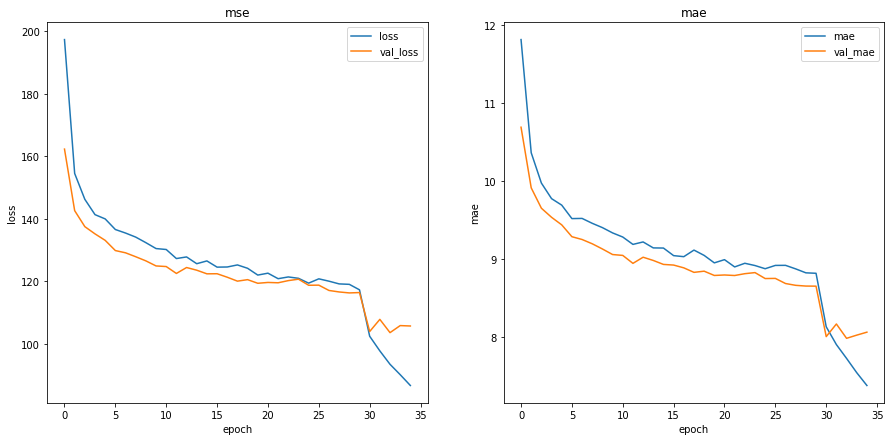

In [53]:
plt.figure(figsize=(15, 7))

plt.subplot(1, 2 ,1)
plt.title('mse')
plt.plot(all_loss, label='loss')
plt.plot(all_val_loss, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('mae')
plt.plot(all_mae, label='mae')
plt.plot(all_val_mae, label='val_mae')
plt.xlabel('epoch')
plt.ylabel('mae')
plt.legend()

plt.show()

In [54]:
model.save('ResNet50_Sample100_Epoch30_Fine10.h5')

In [55]:
notfine_loss = history.history['loss']+history2.history['loss']
notfine_val_loss = history.history['val_loss']+history2.history['val_loss']
notfine_mae = history.history['mae']+history2.history['mae']
notfine_val_mae = history.history['val_mae']+history2.history['val_mae']

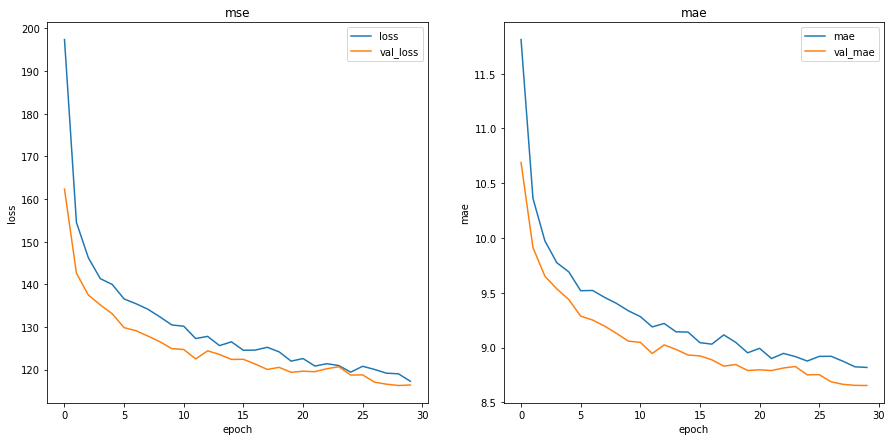

In [56]:
plt.figure(figsize=(15, 7))

plt.subplot(1, 2 ,1)
plt.title('mse')
plt.plot(notfine_loss, label='loss')
plt.plot(notfine_val_loss, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('mae')
plt.plot(notfine_mae, label='mae')
plt.plot(notfine_val_mae, label='val_mae')
plt.xlabel('epoch')
plt.ylabel('mae')
plt.legend()

plt.show()